# Sentiment Analysis

In this notebook two different techniques will be used:
* VADER - Bag of Words;
* Roberta Pretrained Model from HuggingFace.

## Step 0. Read in Data and NLTK basis

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os
import nltk

In [43]:
os.getcwd()

'/Users/sofyakonchakova/Desktop/Data Science/Projects/NLP/Data'

In [44]:
dir = '/Users/sofyakonchakova/Desktop/Data Science/Projects/NLP/Data'
os.chdir(dir)

In [45]:
df = pd.read_csv('Reviews.csv')

In [46]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [47]:
#downsizing the dataset
df = df.head(500)

###  EDA

<AxesSubplot:title={'center':'Count of Reviews by Stars'}>

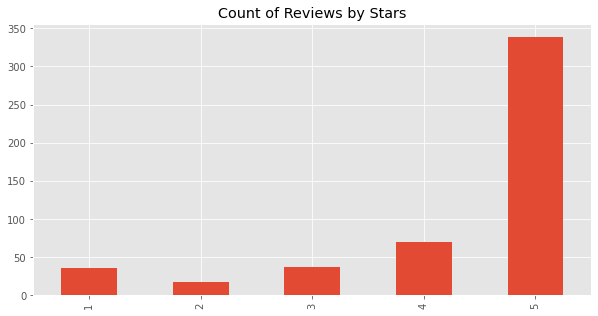

In [48]:
df['Score'].value_counts().sort_index().plot(kind='bar',title="Count of Reviews by Stars", figsize=(10,5))

### Basic NLTK

In [49]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [50]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [51]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [52]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER (Valence Aware Dictionary and sentiment reasoner)

This uses a "bag of words" approach:

1. Stop words are removed
2. Each word is scored and combined to a total score.

Note: does not take into consideration the relationship between words, and do not account for interaction between them.

In [53]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


sia = SentimentIntensityAnalyzer()

In [54]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [55]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [56]:
#Run the polarity scores
res = {}

for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [57]:
vaders = pd.DataFrame(res).T

In [58]:
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how = 'left')

In [59]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


NameError: name 'ax' is not defined

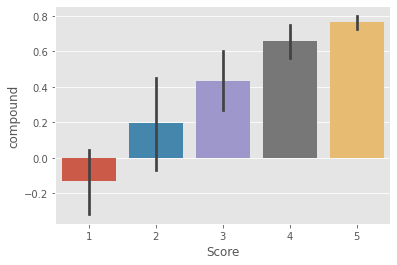

In [60]:
sns.barplot(data=vaders,x="Score",y='compound')
ax.set_title("Compound Score by Amazon Star review")
plt.show()

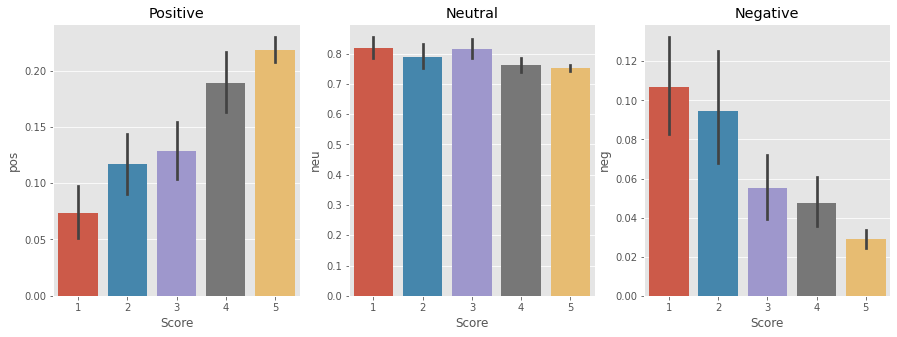

In [61]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders, x= 'Score',  y= 'pos', ax = axs[0])
sns.barplot(data=vaders, x = 'Score', y = 'neu', ax= axs[1])
sns.barplot(data=vaders, x = 'Score', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.show()

## Step 2. Roberta Pretrained Model
* human language depends a lot on context. Some sentences might be sarcastic, and vader model would not pick up relationship on such models.
* 

In [62]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [63]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [66]:
#Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores


array([0.97635514, 0.02068748, 0.00295737], dtype=float32)

In [68]:
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos':scores[2]
}

print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.002957372}


In [69]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict

In [72]:
res = {}

for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result= sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [73]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how = 'left')

In [74]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

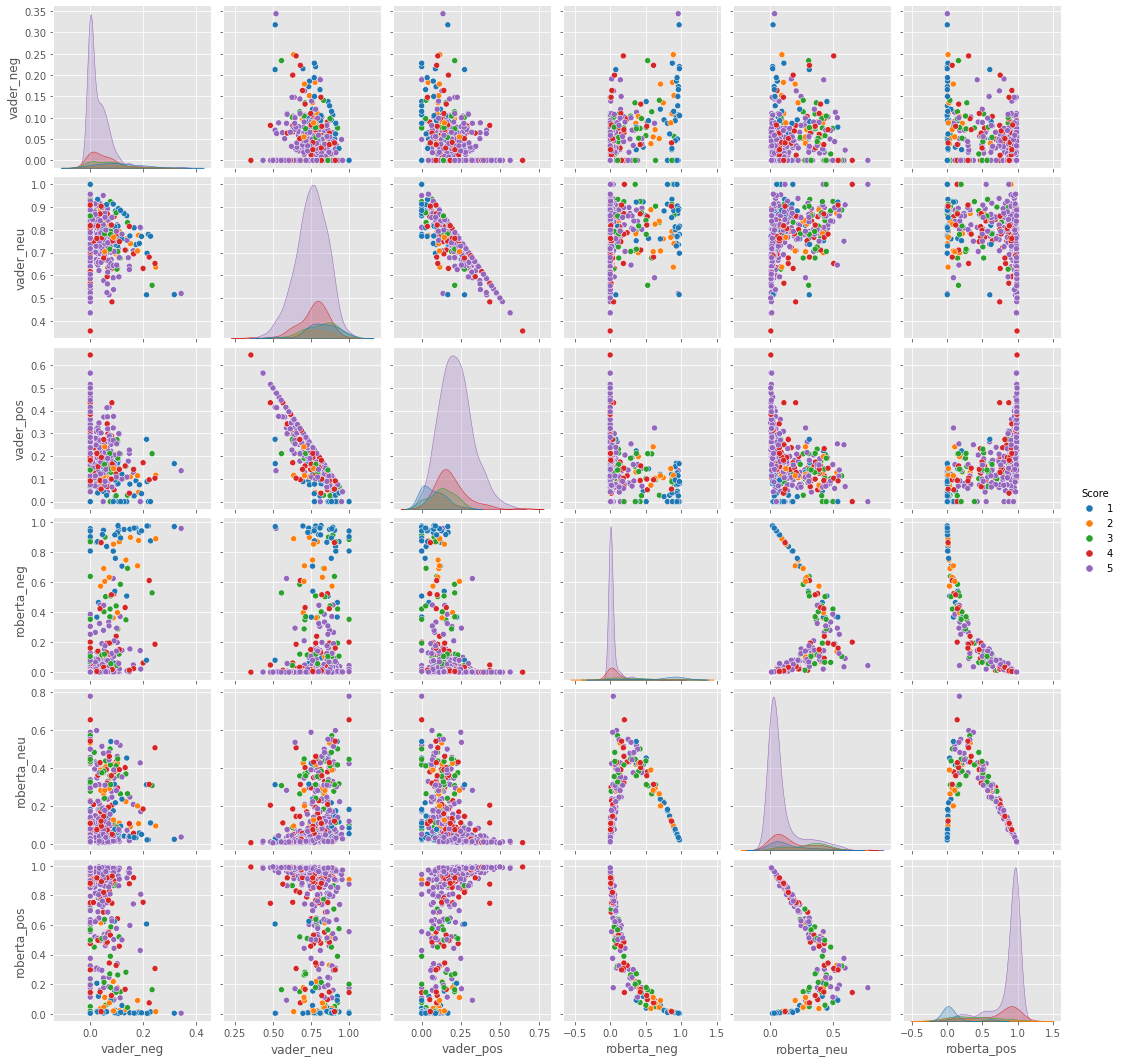

In [76]:
#Compare Scores between models

sns.pairplot(data = results_df, vars = ['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], hue = 'Score', palette = 'tab10')

## Step 3. Review Examples

In [78]:
results_df.query('Score == 1')\
    .sort_values('roberta_pos',ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

## Extra : The Transformers Pipeline

In [79]:
from transformers import pipeline

In [82]:
sent_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [83]:
sent_pipeline('I was struggling at first but at the end I really enjoyed it!')

[{'label': 'POSITIVE', 'score': 0.9998562335968018}]